In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Mestrado/2021.2/Aprendizagem de Maquina/trabalho_06/')

Mounted at /content/drive


# Imports

In [29]:
import pandas as pd
import numpy as np
from src import plots, utils, pipeline as p
import math
import json
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Artificial I

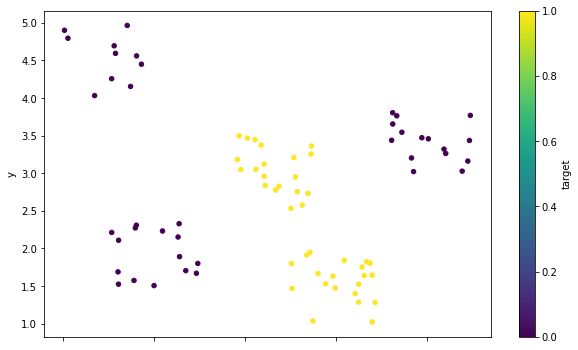

In [48]:
conjunto_1 = utils.make_coords(coord_limit_x = (0, 1), 
                               coord_limit_y = (4, 5),
                               target= 0,
                               len_set = 10) # Top left

conjunto_2 = utils.make_coords(coord_limit_x = (1.75, 2.75), 
                               coord_limit_y = (3.5, 2.5),
                               target= 1,
                               len_set = 20) # Botton left

conjunto_3 = utils.make_coords(coord_limit_x = (2.5, 3.5), 
                               coord_limit_y = (2, 1),
                               target= 1,
                               len_set = 20) # Bottom right
conjunto_4 = utils.make_coords(coord_limit_x = (0.5, 1.5), 
                               coord_limit_y = (1.5, 2.5),
                               target= 0,
                               len_set = 15) # Bottom right

conjunto_5 = utils.make_coords(coord_limit_x = (3.5, 4.5), 
                               coord_limit_y = (3, 4),
                               target= 0,
                               len_set = 15) # Bottom right


df_artificial_1 = pd.DataFrame(data= conjunto_1 + conjunto_2 + conjunto_3 + conjunto_4 + conjunto_5, columns=['x', 'y', 'target'])
# for col in df_artificial_1.columns:
#     if col != 'target':
#         df_artificial_1 = utils.normalize_col(df_artificial_1, col)

df_artificial_1.plot.scatter( x='x', y='y', c='target', colormap='viridis', figsize=(10,6))

In [49]:
df_artificial_1['target'].value_counts()

1    40
0    40
Name: target, dtype: int64

In [56]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_artificial_1.copy(), col_target='target', train_size=0.7, stratify=True)

X_train['target'] = y_train
X_train.reset_index(drop=True, inplace=True)
X_train, y_train = X_train.drop(['target'], axis=1), X_train['target']

X_test['target'] = y_test
X_test.reset_index(drop=True, inplace=True)
X_test, y_test = X_test.drop(['target'], axis=1), X_test['target']

In [57]:
class NormalMultivariate():

    def __init__(self, df, mean=None, cov=None):
        self.df = df
        self.dim = len(df.columns)

        if mean is None: self.mean = np.array([df[col].mean() for col in df.columns  if col != 'target'])
        else: self.mean = np.array(mean)

        if cov is None: self.cov = np.matrix(df.cov().values)
        else: self.cov = cov

        self.det = np.linalg.det(self.cov)
        self.peak_distribution = 1 / (((2 * np.pi) ** (self.dim / 2)) * 
                                      (self.det ** 0.5))

    def pdf(self, x):
        if isinstance(x, pd.core.frame.DataFrame) or isinstance(x[0], list) or isinstance(x[0], np.ndarray) or isinstance(x[0], np.matrix):
            if isinstance(x, pd.core.frame.DataFrame):
                x = x.values
            list_return = []
            for i in x:
                list_return.append(self.__pdf_single_list(i))
            return list_return

        else:
            return self.__pdf_single_list(x)

    def __pdf_single_list(self, x):

        if not isinstance(x, np.ndarray):
            x = np.array(x)
        x_mu = np.matrix(x - self.mean)
        inv = self.cov.I
        return self.peak_distribution * math.pow(math.e, -((x_mu * x_mu.T) / (2 * self.cov)))

In [58]:
class ClassifierBayes():

    def __init__(self, len_window):
        self.k = len_window

    def fit(self, X_train, y_train):
        df_train = X_train.copy()
        df_train['target'] = y_train
        self.list_class = df_train['target'].unique()
        self.features = [col for col in df_train.columns if col != 'target']
    
        self.dict_priori = {}
        self.dict_df_class = {}
        self.dict_norm_class = {}
    
        for j in sorted(self.list_class):
            self.dict_priori[j] = (len(df_train.loc[df_train['target'] == j]) / len(df_train))
            self.dict_df_class[j] = df_train[df_train['target'] == j].copy().reset_index(drop=True)
            self.dict_norm_class[j] = {}
            for idx, _ in self.dict_df_class[j].iterrows():
                x = self.dict_df_class[j][self.features].iloc[idx].tolist()
                self.dict_norm_class[j][idx] = NormalMultivariate(self.dict_df_class[j][self.features], mean=x, cov=np.matrix([[self.k **2]]).I)



    def prob_x(self, xi):
        dict_prob = {}
        for j in sorted(self.list_class):
            list_gaussian = []
            for idx, _ in self.dict_df_class[j].iterrows():
                list_gaussian.append(self.dict_norm_class[j][idx].pdf(xi))
            dict_prob[j] = sum(list_gaussian) / len(self.dict_df_class[j])
            
        return dict_prob

    
    def predict(self, df):

        list_predict = []
        for idx, row in df.iterrows():
    
            x = df[self.features].iloc[idx].tolist()
    
            pdf_priori = []
            dict_posteriori =self.prob_x(x)
            for j in sorted(self.list_class):
                pdf_priori.append(
                    dict_posteriori[j] * self.dict_priori[j]
                )
    
            normalize = sum(pdf_priori)
            prob_class = {}
            prob_max = -1
            class_predict = -1
            for j in sorted(self.list_class): 
                prob_class[j] =  (dict_posteriori[j] * self.dict_priori[j]) / normalize
                if prob_class[j] > prob_max:
                    prob_max = prob_class[j]
                    class_predict = j
    
            list_predict.append(class_predict)
        
        return list_predict

In [59]:
bayes = ClassifierBayes(len_window = 3)
bayes.fit(X_train.copy(), y_train)

In [60]:
X_test['predict'] = bayes.predict(X_test.copy())
X_test['label'] = y_test

In [62]:
print(classification_report(X_test['label'], X_test['predict']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



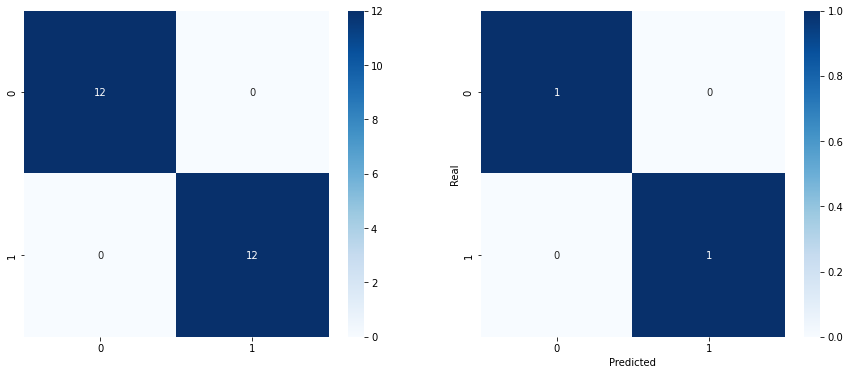

In [64]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(confusion_matrix(X_test['label'], X_test['predict']), annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_matrix(X_test['label'], X_test['predict'], normalize='true'), annot=True, cmap='Blues', ax=axs[1])

plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

In [65]:
from sklearn.datasets import load_iris

In [66]:
data = load_iris()
df_iris = pd.DataFrame(data.data, columns=data.feature_names)
df_iris['target'] = pd.Series(data.target)

In [73]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_iris.copy(), col_target='target', train_size=0.7, stratify=True)

X_train['target'] = y_train
X_train.reset_index(drop=True, inplace=True)
X_train, y_train = X_train.drop(['target'], axis=1), X_train['target']

X_test['target'] = y_test
X_test.reset_index(drop=True, inplace=True)
X_test, y_test = X_test.drop(['target'], axis=1), X_test['target']

In [74]:
bayes = ClassifierBayes(len_window = 2)
bayes.fit(X_train.copy(), y_train)

In [75]:
X_test['predict'] = bayes.predict(X_test.copy())
X_test['label'] = y_test

In [76]:
print(classification_report(X_test['label'], X_test['predict']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.93      0.90        15
           2       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



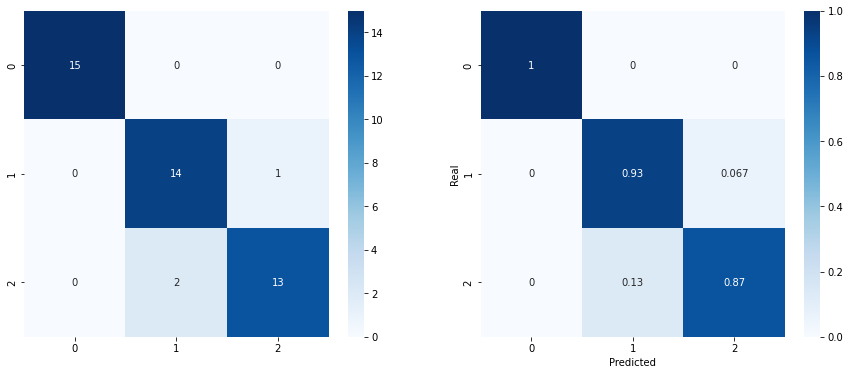

In [77]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(confusion_matrix(X_test['label'], X_test['predict']), annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_matrix(X_test['label'], X_test['predict'], normalize='true'), annot=True, cmap='Blues', ax=axs[1])

plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()